In [45]:
%%capture
##! pip install graphviz
#! pip install pyspssio
#! pip install networkx[default]

In [46]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pyspssio
import re
import networkx as nx

sns.set_palette("pastel")
sns.set_theme(style="whitegrid", palette="pastel", context="notebook")

df, meta = pyspssio.read_sav("29-я волна_репрезентативная выборка_SPSS/ДОМОХОЗЯЙСТВА/r29h_os_71.sav")

In [47]:
print(f'{df.shape=}')
df.head(3)

df.shape=(4830, 1031)


,yredid_h,yid_h,xid_h,wid_h,vid_h,uid_h,tid_h,sid_h,rid_h,qid_h,...,yf14.12,yf14.13,yf14.14,yf14.15,yf14,yf16.1,yf16.2,yf16.3,yf16.4,yf16.5
0,1017.0,10003.0,10003.0,10003.0,10003.0,10003.0,10003.0,10003.0,10003.0,10003.0,...,2.0,NaN,2.0,NaN,17376.0,2.0,99999996.0,2.0,2.0,99999996.0
1,1018.0,10004.0,10004.0,NaN,10004.0,10004.0,10004.0,10004.0,10004.0,10004.0,...,2.0,NaN,2.0,NaN,37500.0,2.0,99999996.0,99999996.0,2.0,1.0
2,1020.0,10012.0,10012.0,10012.0,10012.0,10012.0,10012.0,10012.0,10012.0,10012.0,...,2.0,NaN,2.0,NaN,19700.0,99999996.0,99999996.0,99999996.0,2.0,1.0


In [48]:
meta.keys()

dict_keys(['file_attributes', 'encoding', 'case_count', 'case_weight_var', 'mrsets', 'var_names', 'var_types', 'var_formats', 'var_formats_tuple', 'var_labels', 'var_alignments', 'var_column_widths', 'var_measure_levels', 'var_roles', 'var_missing_values', 'var_value_labels', 'var_attributes', 'var_compat_names'])

In [49]:
df['y_nfm'].value_counts()

y_nfm
2.0     1469
1.0     1307
3.0      907
4.0      643
5.0      277
6.0      120
7.0       46
8.0       25
9.0       18
10.0      10
11.0       6
16.0       1
14.0       1
Name: count, dtype: int64

ЭЭЭЭЭЭКСПЕРИМЕНТЫ

In [50]:
def create_nodes(seriya, max_chlenov_dh=20):
    nodes = []
    for num_chlen in range(1, max_chlenov_dh+1):
        if (pd.notna(seriya[f'yb{num_chlen}.1'])) & (seriya[f'yb{num_chlen}.2.1']==1):
            
            ind_number = seriya[f'yidind{num_chlen}']
            
            pol_value = seriya[f'yb{num_chlen}.4']
            pol = None if pd.isna(pol_value) else ('male' if pol_value==1 else 'female' if pol_value==2 else None)
            
            birth_year_value = seriya[f'yb{num_chlen}.5']
            birth_year = None if pd.isna(birth_year_value) else birth_year_value
            
            node = (
                num_chlen,
                {
                'ind_number': ind_number, #'Индивидуальный номер 1-го члена семьи'
                'pol': pol, #'Какого пола этот человек?',
                'birth_year': birth_year, #'В каком году (он/она) родились?'
                }
            )
            nodes.append(node)
        
    return nodes

In [51]:
def create_edges(seriya, nodes_num, max_chlenov_dh=20):
    connection_names = {
        1: 'suprug',
        2: 'blood_ditya',
        3: 'priyem_ditya'
    }
    edges = []
    for node_otkuda_num in range(1, max_chlenov_dh+1):
        for node_kuda_num in range(1, node_otkuda_num):
            if node_otkuda_num in nodes_num and node_kuda_num in nodes_num:
                if node_otkuda_num<=16 and node_kuda_num>=10:
                    edge_type = seriya[f'yb{node_otkuda_num}9.{node_kuda_num}']
                elif node_otkuda_num>=17 and node_kuda_num>=10:
                    edge_type = seriya[f'yb{node_otkuda_num}.9{node_kuda_num}']
                else:
                    edge_type = seriya[f'yb{node_otkuda_num}.9.{node_kuda_num}']
                
                if edge_type in [1, 2, 3, 4, 5]:
                    if edge_type == 4:
                        node_otkuda, node_kuda = node_kuda_num, node_otkuda_num
                        edge_type = 2
                    elif edge_type == 5:
                        node_otkuda, node_kuda = node_kuda_num, node_otkuda_num
                        edge_type = 3
                    else:
                        node_otkuda, node_kuda = node_otkuda_num, node_kuda_num
                        if edge_type==1:
                            edges.append((node_kuda, node_otkuda, {'edge_type': connection_names[edge_type]}))

                    edge = (
                        node_otkuda,
                        node_kuda,
                        {
                            'edge_type': connection_names[edge_type], #'Кем 2-ой член семьи приходится 1-му члену семьи?'
                        }
                    ) 
                    edges.append(edge)
            
    return edges

In [52]:
problems = [31, 140, 213, 399]
seriya = df.iloc[problems[0]]
nodes = create_nodes(seriya)
nodes_num = [node[0] for node in nodes]
print(nodes_num)
edges = create_edges(seriya, nodes_num)


[2, 8, 12]


In [53]:
def baboushka_edges(seriya, nodes_num, edges, max_chlenov_dh=20):
    extended_edges = []
    for node_otkuda_num in range(1, max_chlenov_dh+1):
        for node_kuda_num in range(1, node_otkuda_num):
            if node_otkuda_num in nodes_num and node_kuda_num in nodes_num:
                if node_otkuda_num<=16 and node_kuda_num>=10:
                    edge_type = seriya[f'yb{node_otkuda_num}9.{node_kuda_num}']
                elif node_otkuda_num>=17 and node_kuda_num>=10:
                    edge_type = seriya[f'yb{node_otkuda_num}.9{node_kuda_num}']
                else:
                    edge_type = seriya[f'yb{node_otkuda_num}.9.{node_kuda_num}']
                    
                if edge_type in [8, 9]:    
                    if edge_type == 9:
                        node_otkuda, node_kuda = node_kuda_num, node_otkuda_num
                        edge_type = 8
                    elif edge_type == 8:
                        node_otkuda, node_kuda = node_otkuda_num, node_kuda_num
                    
                    relevant_edges = [e for e in edges if (e[0]==node_otkuda and e[2]['edge_type']!='blood_ditya')]
                    if len(relevant_edges)==0:
                        edge = (
                            node_otkuda,
                            node_kuda,
                            {
                                'edge_type': 'vnuk', #'Кем 2-ой член семьи приходится 1-му члену семьи?'
                            }
                        ) 
                        extended_edges.append(edge)
                                
    return extended_edges

In [54]:
def form_graph(seriya, max_chlenov_dh=20):
    graph = nx.DiGraph()
    
    nodes = create_nodes(seriya, max_chlenov_dh)
    graph.add_nodes_from(nodes)
    
    nodes_num = [node[0] for node in nodes]
    edges = create_edges(seriya, nodes_num=nodes_num, max_chlenov_dh=max_chlenov_dh)
    
    extended_edges = baboushka_edges(seriya, nodes_num, edges, max_chlenov_dh=20)
    
    all_edges = edges + extended_edges
    
    graph.add_edges_from(all_edges)
    return graph

In [55]:
#кто проходил опросник, сколько человек в семье
#надо наверное сделать класс
def family_meta_info(seriya, max_chlenov_dh=20):
    who_pass_form = seriya['ya8']
    family_members_num = seriya['y_nfm']
    return who_pass_form, family_members_num

In [56]:
nodes

[(2, {'ind_number': 141.0, 'pol': 'female', 'birth_year': 1937.0}),
 (8, {'ind_number': 16281.0, 'pol': 'female', 'birth_year': 1999.0}),
 (12, {'ind_number': 57092.0, 'pol': 'male', 'birth_year': 2016.0})]

In [57]:
edges

[(8, 12, {'edge_type': 'blood_ditya'})]

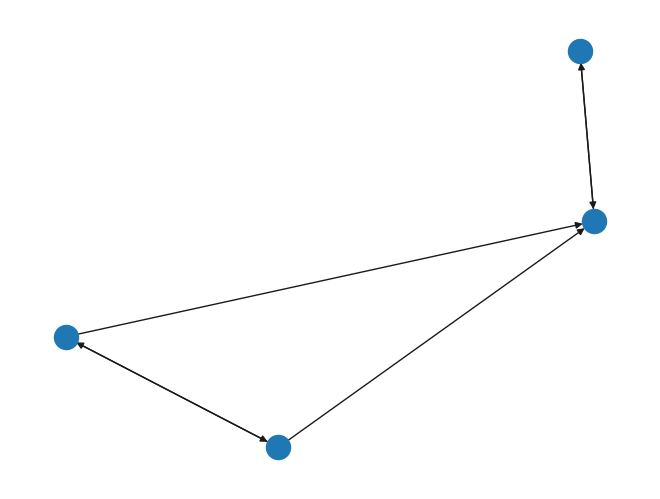

In [58]:
for family_num in [random.randint(0, 4829) for ii in range(1)]:

    seriya = df.iloc[family_num]

    who_pass_form, family_members_num = family_meta_info(seriya)

    nodes = create_nodes(seriya)
    nodes_num = [node[0] for node in nodes]

    edges = create_edges(seriya, nodes_num=nodes_num)

    extended_edges = baboushka_edges(seriya, nodes_num, edges, max_chlenov_dh=20)

    all_edges = edges + extended_edges

    graph = form_graph(seriya)

    nx.draw(form_graph(seriya))
    
    #time.sleep(2)

In [59]:
def who_lives_here(nodes, structured=True):
    if structured:
        nodes_num = [node[0] for node in nodes]
    else:
        nodes_num = nodes        
    return nodes_num

In [60]:
nodes_num

[1, 2, 3, 4]

In [61]:
def create_relationship_matrix(seriya, nodes_num, max_members=20):
    # Создаем пустую матрицу размером max_members x max_members
    matrix = np.full((max_members, max_members), '', dtype=object)
    
    for node_otkuda_num in range(1, max_members+1):
        for node_kuda_num in range(1, node_otkuda_num):
            if node_otkuda_num in nodes_num and node_kuda_num in nodes_num:
                if node_otkuda_num<=16 and node_kuda_num>=10:
                    edge_type = seriya[f'yb{node_otkuda_num}9.{node_kuda_num}']
                elif node_otkuda_num>=17 and node_kuda_num>=10:
                    edge_type = seriya[f'yb{node_otkuda_num}.9{node_kuda_num}']
                else:
                    edge_type = seriya[f'yb{node_otkuda_num}.9.{node_kuda_num}']
                
                if not pd.isna(edge_type):
                    matrix[node_otkuda_num, node_kuda_num] = edge_type  # связь кем i приходтися j

    # Преобразуем матрицу в DataFrame для удобства
    matrix_df = pd.DataFrame(matrix, 
                             columns=[f'{i}' for i in range(max_members)],
                             index=[f'{i}' for i in range(max_members)]).iloc[nodes_num[1:], nodes_num[0:len(nodes_num)-1]]

    return matrix_df


seriya = df.iloc[77]
nodes = create_nodes(seriya)
nodes_num = who_lives_here(nodes)
# Генерируем матрицу связей
relationship_matrix = create_relationship_matrix(seriya, nodes_num)
relationship_matrix

,1,2,3
2,1.0,,
3,4.0,4.0,
4,4.0,4.0,6.0


In [62]:
def base_edges(relationship_matrix):
    connection_names = {
        1: 'suprug',
        2: 'blood_ditya',
        3: 'priyem_ditya'
    }
    base_edges = []
    for node_kuda_num in relationship_matrix.index:
        for node_otkuda_num in relationship_matrix.columns:
            if node_kuda_num>node_otkuda_num:
                edge_type = relationship_matrix.loc[node_kuda_num, node_otkuda_num]
                if edge_type in [1, 2, 3, 4, 5]:
                    if edge_type == 4:
                        node_otkuda, node_kuda = node_otkuda_num, node_kuda_num
                        edge_type = 2
                    elif edge_type == 5:
                        node_otkuda, node_kuda = node_otkuda_num, node_kuda_num
                        edge_type = 3
                    else:
                        node_kuda, node_otkuda = node_otkuda_num, node_kuda_num
                        if edge_type==1:
                            base_edges.append((node_kuda, node_otkuda, {'edge_type': connection_names[edge_type]}))  
                    edge = (
                        node_otkuda,
                        node_kuda,
                        {
                            'edge_type': connection_names[edge_type], #'Кем 2-ой член семьи приходится 1-му члену семьи?'
                        }
                    ) 
                    base_edges.append(edge)
                    
    return base_edges

In [63]:
base_edges(relationship_matrix)

[('1', '2', {'edge_type': 'suprug'}),
 ('2', '1', {'edge_type': 'suprug'}),
 ('1', '3', {'edge_type': 'blood_ditya'}),
 ('2', '3', {'edge_type': 'blood_ditya'}),
 ('1', '4', {'edge_type': 'blood_ditya'}),
 ('2', '4', {'edge_type': 'blood_ditya'})]

In [64]:
nodes

[(1, {'ind_number': 32380.0, 'pol': 'female', 'birth_year': 1972.0}),
 (2, {'ind_number': 32381.0, 'pol': 'male', 'birth_year': 1972.0}),
 (3, {'ind_number': 32382.0, 'pol': 'male', 'birth_year': 1998.0}),
 (4, {'ind_number': 32383.0, 'pol': 'female', 'birth_year': 2002.0})]

In [65]:
df_ind, meta_ind = pyspssio.read_sav("29-я волна_репрезентативная выборка_SPSS/ИНДИВИДЫ/r29i_os_73.sav")
df_ind.head()

,idind,yid_i,yredid_i,yid_h,xid_i,xid_h,wid_i,wid_h,vid_i,vid_h,...,ym191.6,ym111,ys1.1,ys1.2,ys2,ys3,ys4,ys5,ys6,ys7
0,3.0,1001201.0,102001.0,10012.0,1001201.0,10012.0,1001201.0,10012.0,1001201.0,10012.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.0,1000301.0,101701.0,10003.0,1000301.0,10003.0,1000301.0,10003.0,1000301.0,10003.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.0,1000401.0,101801.0,10004.0,1000401.0,10004.0,NaN,NaN,1000401.0,10004.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36.0,1002401.0,102601.0,10024.0,1002401.0,10024.0,1002401.0,10024.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,60.0,1004702.0,104002.0,10047.0,1004702.0,10047.0,1004702.0,10047.0,1004702.0,10047.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
df_ind[df_ind['idind']==33750]

,idind,yid_i,yredid_i,yid_h,xid_i,xid_h,wid_i,wid_h,vid_i,vid_h,...,ym191.6,ym111,ys1.1,ys1.2,ys2,ys3,ys4,ys5,ys6,ys7
4266,33750.0,39026201.0,445101.0,390262.0,39026201.0,390262.0,39026201.0,390262.0,39026201.0,390262.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
seriya = df.iloc[777]
nodes = create_nodes(seriya)
nodes_num = who_lives_here(nodes)

In [68]:
i = 4
id_ind_from_dh = nodes[i][1]['ind_number']
seriya_ind = df_ind.loc[(df_ind['idind']==id_ind_from_dh)].squeeze()
seriya_ind['y_marst']

2.0

In [69]:
58740.0
df_ind.loc[(df_ind['idind']==58740.0)].squeeze()['y_marst']

3.0

In [70]:
nodes

[(1, {'ind_number': 33750.0, 'pol': 'male', 'birth_year': 1972.0}),
 (2, {'ind_number': 33751.0, 'pol': 'female', 'birth_year': 1976.0}),
 (3, {'ind_number': 33752.0, 'pol': 'female', 'birth_year': 1997.0}),
 (4, {'ind_number': 33753.0, 'pol': 'female', 'birth_year': 2003.0}),
 (5, {'ind_number': 50515.0, 'pol': 'male', 'birth_year': 1998.0}),
 (6, {'ind_number': 50516.0, 'pol': 'male', 'birth_year': 2014.0})]

In [71]:
# получаем узлы и инфо про них из файла с дх
# добавляем инфу, если есть, из файла индивидов
# строим матрицу связей
# строим первичный граф
# заменяем супругов на сожителей при помощи инфы из файла индивидов
# добавляем бабушек без детей в дх
# граф готов, теперь можно применять всякие функции

In [72]:
nodes[5]

(6, {'ind_number': 50516.0, 'pol': 'male', 'birth_year': 2014.0})

In [80]:
nodes

[(1,
  {'ind_number': 32528.0,
   'pol': 'female',
   'birth_year': 1953.0,
   'is_adult': True,
   'is_sozhit': False})]

In [79]:
info_from_ind_for_one_node(nodes, df_ind)

[(1, {'is_adult': True, 'is_sozhit': False})]

In [81]:
# у меня тут изменяются узлы и связи на месте, а не возвращаются
def info_from_ind_for_one_node(nodes, df_ind):
    #еще вариант: функция возвращает update_itm
    for node in nodes:
        update_items = {
            'is_adult': True,
            'is_sozhit': False,
            #nation,
            #profession,
            #obrazovaniye
        }
        if node[1]['ind_number'] in df_ind['idind'].tolist():
            seriya_ind = df_ind.loc[(df_ind['idind']==node[1]['ind_number'])].squeeze()
            
            is_adult_value = seriya_ind['y_child']
            is_adult = False if is_adult_value==1 else True
            update_items['is_adult'] = is_adult
            
            is_sozhit_value = seriya_ind['y_marst']
            is_sozhit = True if is_sozhit_value==3 else False
            update_items['is_sozhit'] = is_sozhit

            node[1].update(update_items)
    
    return nodes
            
        

def change_brak_to_sozhit(nodes, edges):
    edges_new = edges
    for edge in edges:
        ind_1_num = edge[0]
        ind_2_num = edge[1]
        ind_1 = [node for node in nodes if node[0]==ind_1_num][0]
        ind_2 = [node for node in nodes if node[0]==ind_2_num][0]

        if ((edge[2]['edge_type'] == 'suprug') or (edge[2]['edge_type'] == 'sozhitel')) and ((ind_1[1]['is_sozhit']==True ) or (ind_2[1]['is_sozhit']==True)):
            edge[2]['edge_type'] = 'sozhitel'
            
    return edges_new

In [ ]:
# у меня тут изменяются узлы и связи на месте, а не возвращаются
def info_from_ind_for_one_node(nodes, df_ind):
    #еще вариант: функция возвращает update_itm
    info_from_ind = []
    for node in nodes:
        update_items = {
            'is_adult': True,
            'is_sozhit': False,
            #nation,
            #profession,
            #obrazovaniye
        }
        if node[1]['ind_number'] in df_ind['idind'].tolist():
            seriya_ind = df_ind.loc[(df_ind['idind']==node[1]['ind_number'])].squeeze()
            
            is_adult_value = seriya_ind['y_child']
            is_adult = False if is_adult_value==1 else True
            update_items['is_adult'] = is_adult
            
            is_sozhit_value = seriya_ind['y_marst']
            is_sozhit = True if is_sozhit_value==3 else False
            update_items['is_sozhit'] = is_sozhit

            info_from_ind.append((node[0], update_items))
    
    return info_from_ind

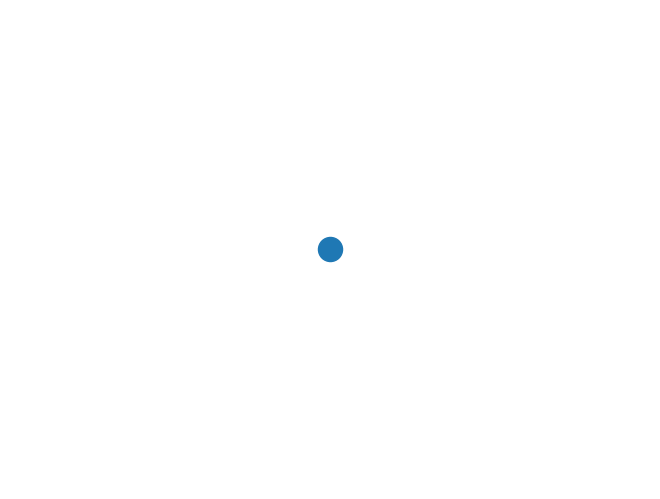

In [74]:
for family_num in [random.randint(0, 4829) for ii in range(1)]:

    seriya = df.iloc[family_num]

    who_pass_form, family_members_num = family_meta_info(seriya)

    nodes = create_nodes(seriya)
    nodes_num = [node[0] for node in nodes]

    edges = create_edges(seriya, nodes_num=nodes_num)

    extended_edges = baboushka_edges(seriya, nodes_num, edges, max_chlenov_dh=20)

    all_edges = edges + extended_edges

    graph = form_graph(seriya)

    nx.draw(form_graph(seriya))
    
    #time.sleep(2)

In [75]:
nodes

[(1, {'ind_number': 32528.0, 'pol': 'female', 'birth_year': 1953.0})]

In [76]:
edges

[]

In [82]:
change_brak_to_sozhit(info_from_ind_for_one_node(nodes, df_ind), edges)

[]